# Temperature global map

This notebook gets the spatial variability in the temperature error, relative to a control ensemble.

# 1. Process raw data

In [91]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import sys


#Functions

def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature    
    return temperature.latitude



    
def process_nc_file(f,correct_latitude_values):    
    
    #Get data 
    ds = xr.open_dataset(f)
    
        
    #Reset the latitude
    ds = ds.assign_coords(latitude=(correct_latitude_values))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    

    #Just get the surface temperature
    temperature = ds.temperature
    
    if temperature.shape != (365, 8, 48, 96):
        return False #Exit function and don't use this one
    surface_temperature = temperature[:,0]                  # Just get surface temperature
    df = surface_temperature.to_dataframe().reset_index()   # And make it a df
    df['weight']= np.cos(np.deg2rad(df.latitude))           # Get weights
    df['weighted_temperature']=  df.weight*df.temperature   # And weighted temperature
    
    df_out = df.groupby(['latitude', 'longitude']).mean().reset_index() #i.e. average over 1 year    
    ds.close()
    return df_out
    

def global_average(list_of_files,p):
    
    """
    Average over all ensemble members (m0,m1 etc) and all times
    """

    
    # Get the global weights at full precision.
    correct_latitude_values = get_global_weights()
    #weights = np.cos(np.deg2rad(correct_latitude_values))
    #weights.name = "weights"
    
    
    dfs = []
    for n in tqdm(list_of_files):
        temperature = process_nc_file(n,correct_latitude_values) # this is a df of the surface temperature for that file, averaged over the year
        if temperature is not False:   #False if the shape isnt correct
                dfs.append(temperature)
          
    #Concat everything together
    df = pd.concat(dfs)
    
    #Groupby
    df_g = df.groupby(['latitude', 'longitude']).mean().reset_index() #i.e. average over all time and ensemble members
    
    #Save it  
    fname = f'data/{p}_global_average_map.pkl'
    print('ALl iterations completed. Now saving to file:', fname)
    pd.to_pickle(df_g,fname)
    
    return df_g
    
    



In [92]:
#First get control
root= f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/'
control_files = sorted(glob.glob(root + 'tmp_control/*/model_output*.nc'))
dfcontrol = global_average(control_files,'control')

  0%|          | 0/503 [00:00<?, ?it/s]

ALl iterations completed. Now saving to file: data/control_global_average_map.pkl


In [93]:
competitor_52RN_files = sorted(glob.glob(root+'tmp_m*/speedyone100yr_L2_52_RN_*/model_output*.nc'))      #Un nested
competitor_10SR_files = sorted(glob.glob(root+'tmp_m*/speedyone100yr_L2_10_SR_*/**/model_output*.nc'))   #Nested
competitor_10RN_files = glob.glob(root + f'tmp_m*/speedyone100yr_L2_10_RN_*/model_output*.nc') + glob.glob(root + f'tmp_m*/speedyone100yr_L2_10_RN_*/**/model_output*.nc') #Both


#For now, dont use m9 files
competitor_52RN_files_m9 = sorted(glob.glob(root+'tmp_m9/speedyone100yr_L2_52_RN_m9/model_output*.nc'))  
competitor_10SR_files_m9 = sorted(glob.glob(root+'tmp_m9/speedyone100yr_L2_10_SR_m9/**/model_output*.nc'))  
competitor_10RN_files_m9 = sorted(glob.glob(root+'tmp_m9/speedyone100yr_L2_10_RN_m9/**/model_output*.nc'))  


competitor_52RN_files = sorted(list(set(competitor_52RN_files) - set(competitor_52RN_files_m9))) 
competitor_10SR_files = sorted(list(set(competitor_10SR_files) - set(competitor_10SR_files_m9))) 
competitor_10RN_files = sorted(list(set(competitor_10RN_files) - set(competitor_10RN_files_m9))) 



In [ ]:
df52 = global_average(competitor_52RN_files,'52RN')
dfSR = global_average(competitor_10SR_files,'10SR')
df10 = global_average(competitor_10RN_files,'10RN')

  0%|          | 0/404 [00:00<?, ?it/s]

# 2. Plot it

In [85]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

def RobinsonPlotDev(df,cmap,lower_limit, upper_limit,nlevs,savefig,show_cbar):
    
    
    
    dftmp = df[['latitude','longitude','weighted_temperature']].copy() #Make a copy
    dfpivot = dftmp.pivot('longitude', 'latitude') #Pivot onto lon/lat

    #Extract data into arrays
    lat=dfpivot.columns.levels[1].values
    lon=dfpivot.index.values
    data=dfpivot.values.T


    #Setup plotting env
    fig = plt.figure(figsize=[24,12])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    
    
    if (lower_limit is None) & (upper_limit is None):
        levels = nlevs
    else:
        levels = np.linspace(lower_limit,upper_limit,nlevs)
    

    data, lon = add_cyclic_point(data, coord=lon) #https://stackoverflow.com/questions/56348136/white-line-in-contour-plot-in-cartopy-on-center-longitude
    contourf_ = ax.contourf(lon, lat, data,levels=levels,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap) #this has to be PlateCarree https://stackoverflow.com/questions/56761472/lack-of-projection-for-cartopy-contour
    
    print ('Limits:', min(data.flatten()), max(data.flatten()))
    
    if show_cbar:
        cb = fig.colorbar(contourf_,orientation="horizontal",ax=ax,fraction=0.046, pad=0.04,ticks=[-1, 0, 1])
        cb.ax.tick_params(labelsize=16)
        cb.set_label('K',fontsize=16)
    #tick_params(labelsize=font_size)
    ax.coastlines()
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)
    
    plt.show()
    

In [98]:
dfcontrol = pd.read_pickle('data/control_global_average_map.pkl')
df52 = pd.read_pickle('data/52RN_global_average_map.pkl')
dfSR = pd.read_pickle('data/10SR_global_average_map.pkl')
df10 = pd.read_pickle('data/10RN_global_average_map.pkl')

Limits: 12.361929344361256 305.99821740052107


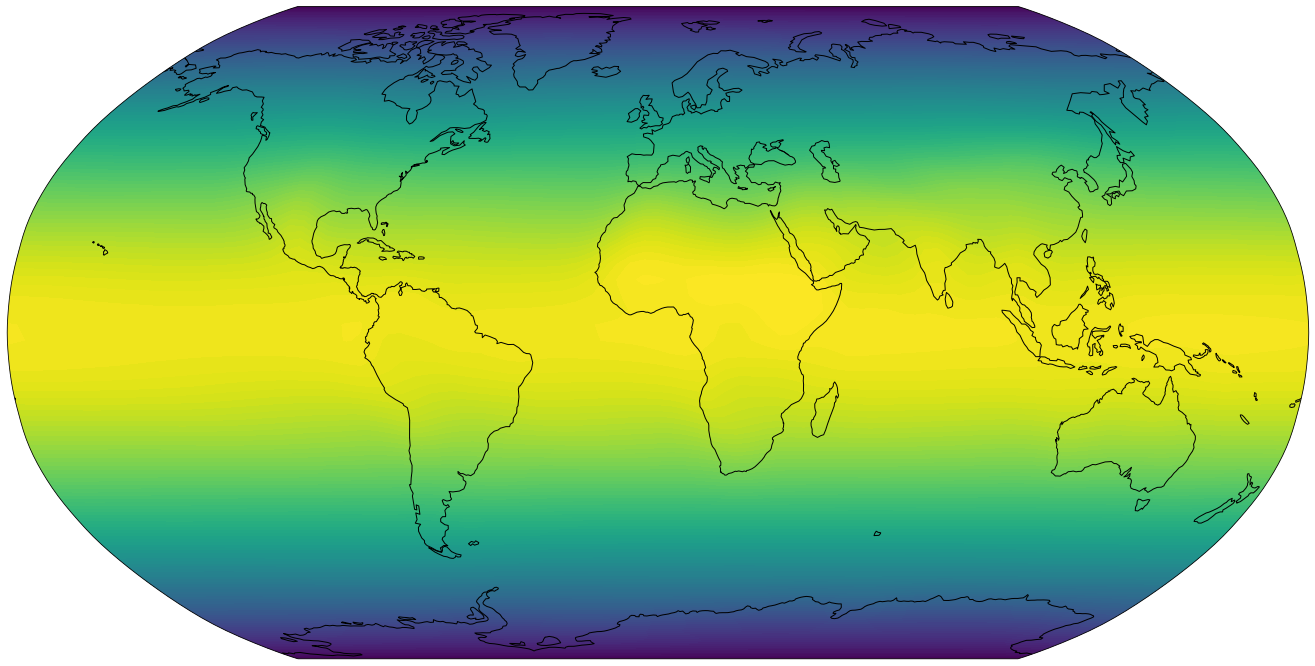

Limits: 12.361475796354057 306.0120617957499


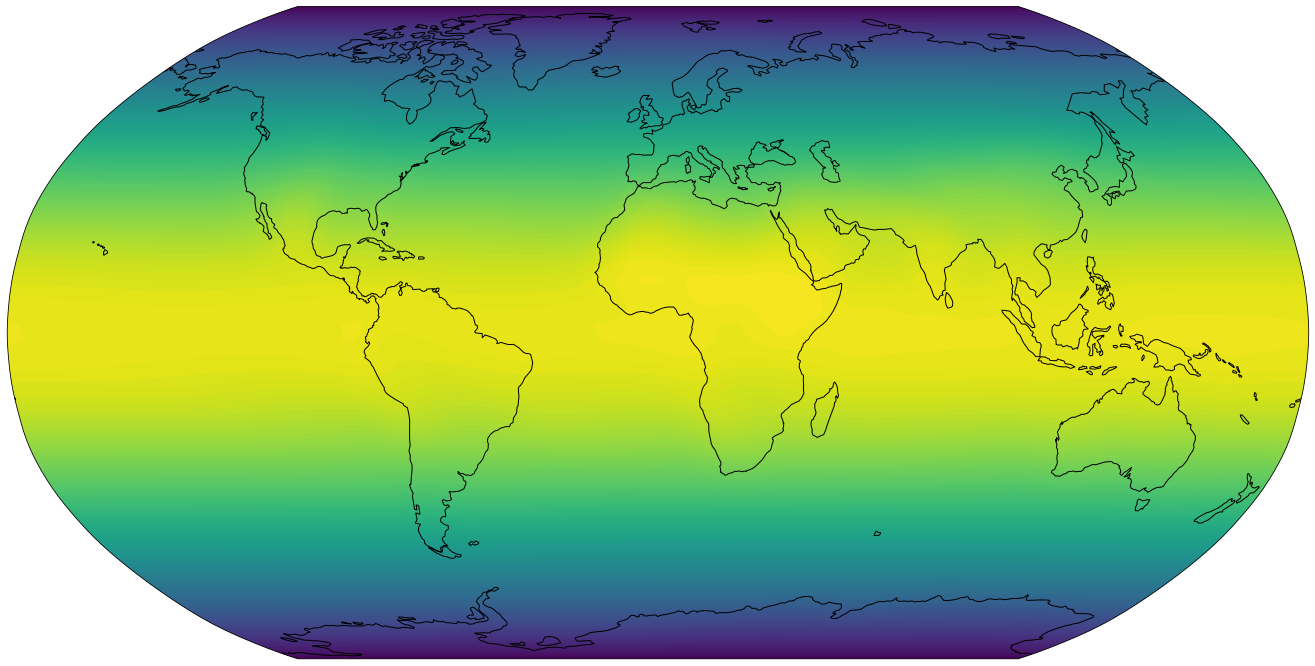

Limits: 12.362899501223598 306.0133026730189


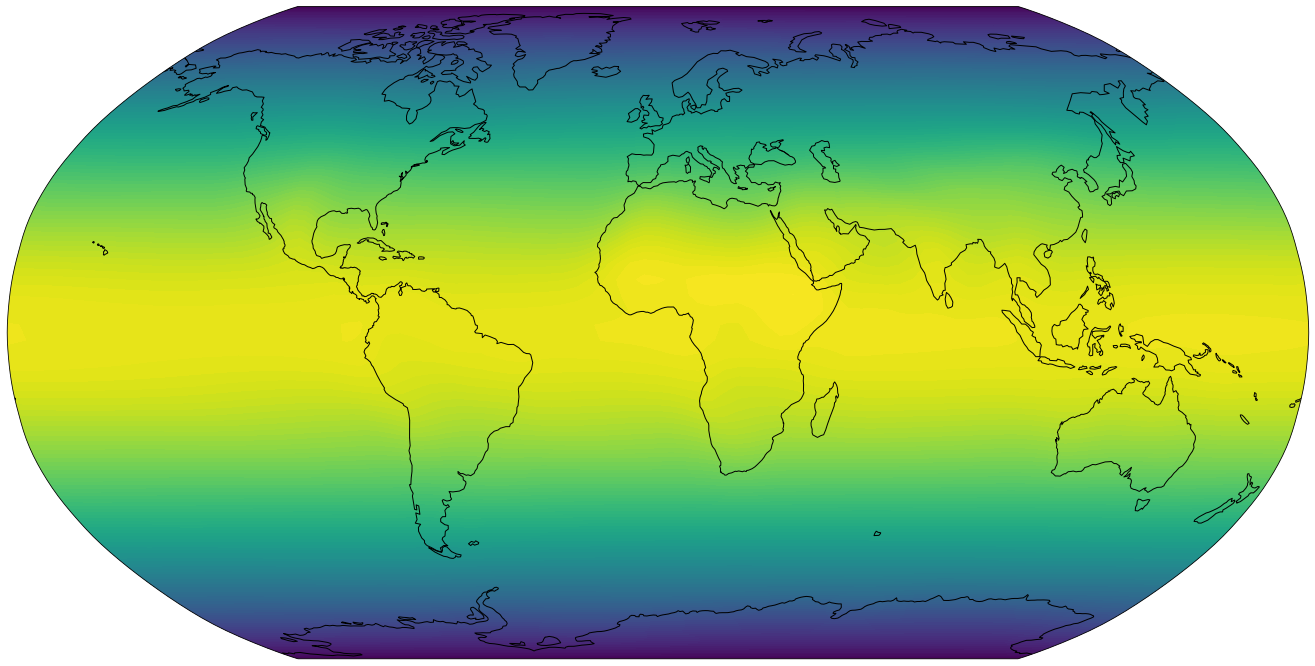

Limits: 12.339301707339626 306.076875976699


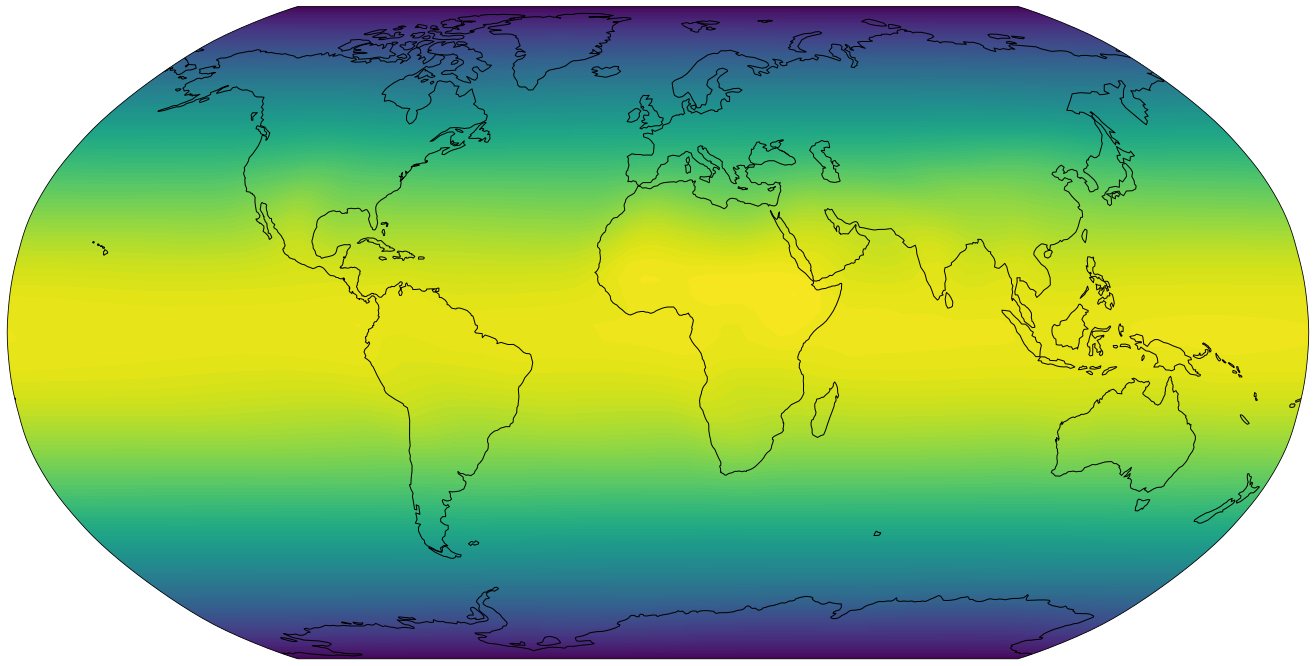

In [99]:
RobinsonPlotDev(dfcontrol,plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(df52,     plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(dfSR,     plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(df10,     plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)

In [101]:

#Subtract one from other
subs52 = dfcontrol.copy()
subs52['weighted_temperature'] = dfcontrol.weighted_temperature - df52.weighted_temperature

subsSR = dfcontrol.copy()
subsSR['weighted_temperature'] = dfcontrol.weighted_temperature - dfSR.weighted_temperature

subs10 = dfcontrol.copy()
subs10['weighted_temperature'] = dfcontrol.weighted_temperature - df10.weighted_temperature


Limits: -0.04908454595801004 0.05516190352543049


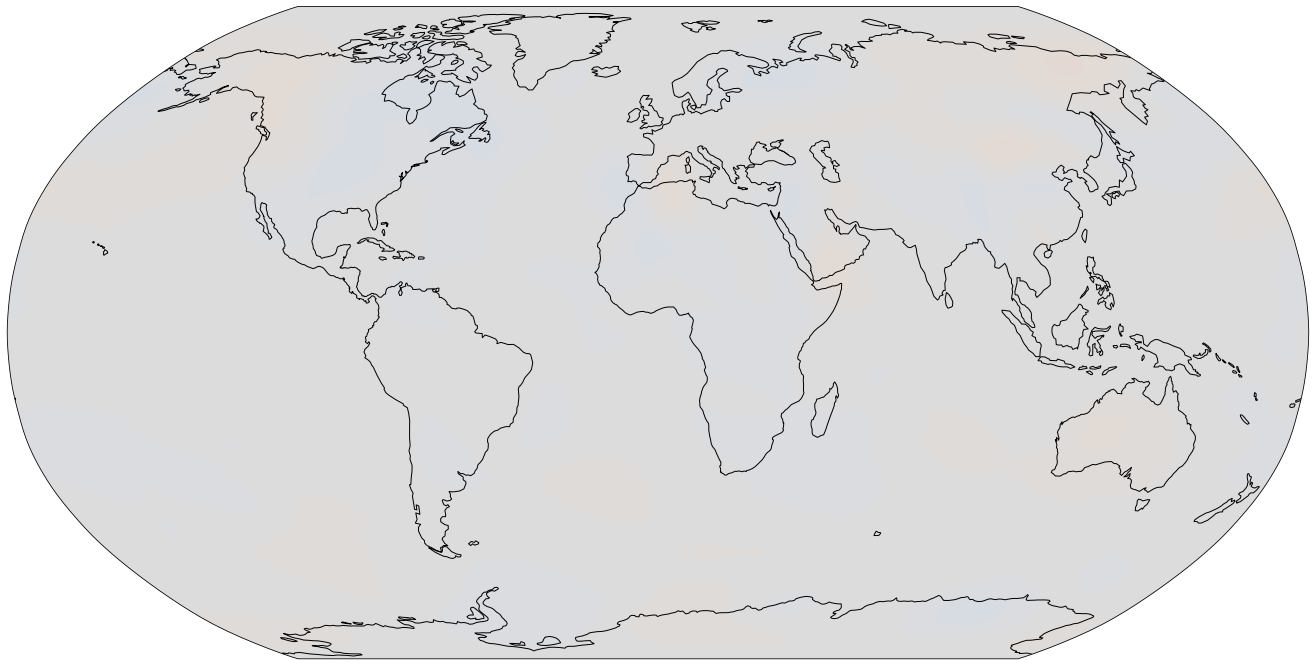

Limits: -0.12952734541835298 0.10758703506648715


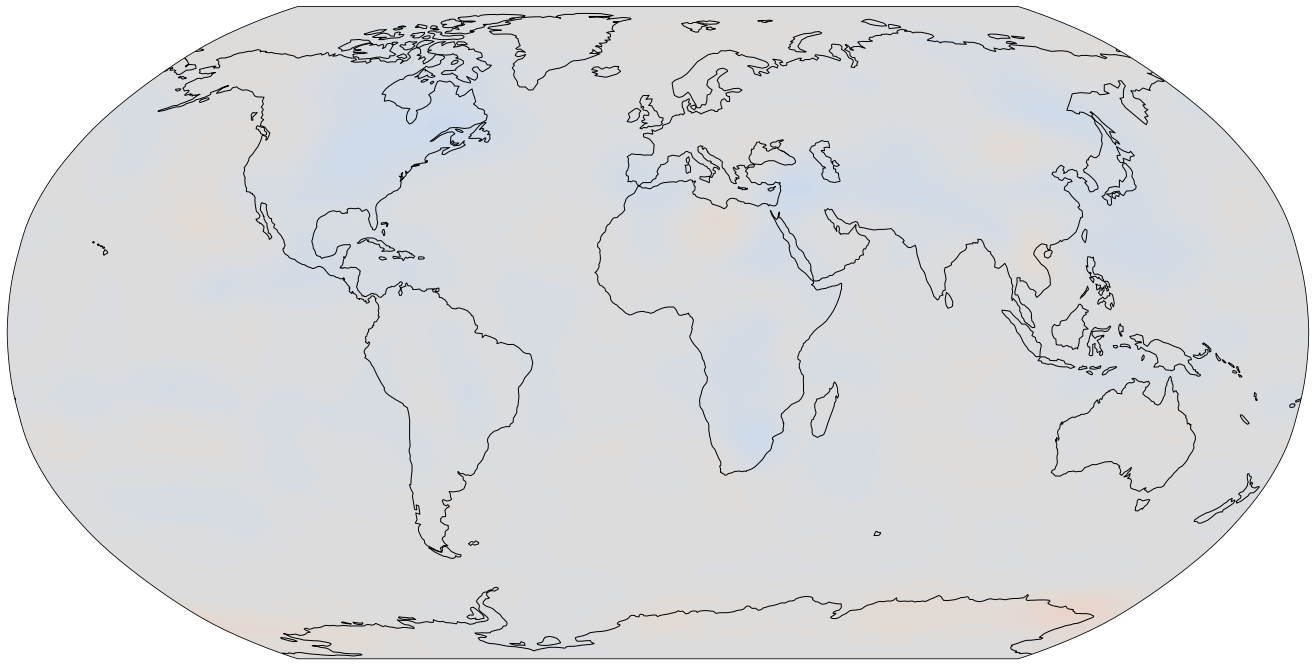

Limits: -0.7746866285868066 0.393384657519789


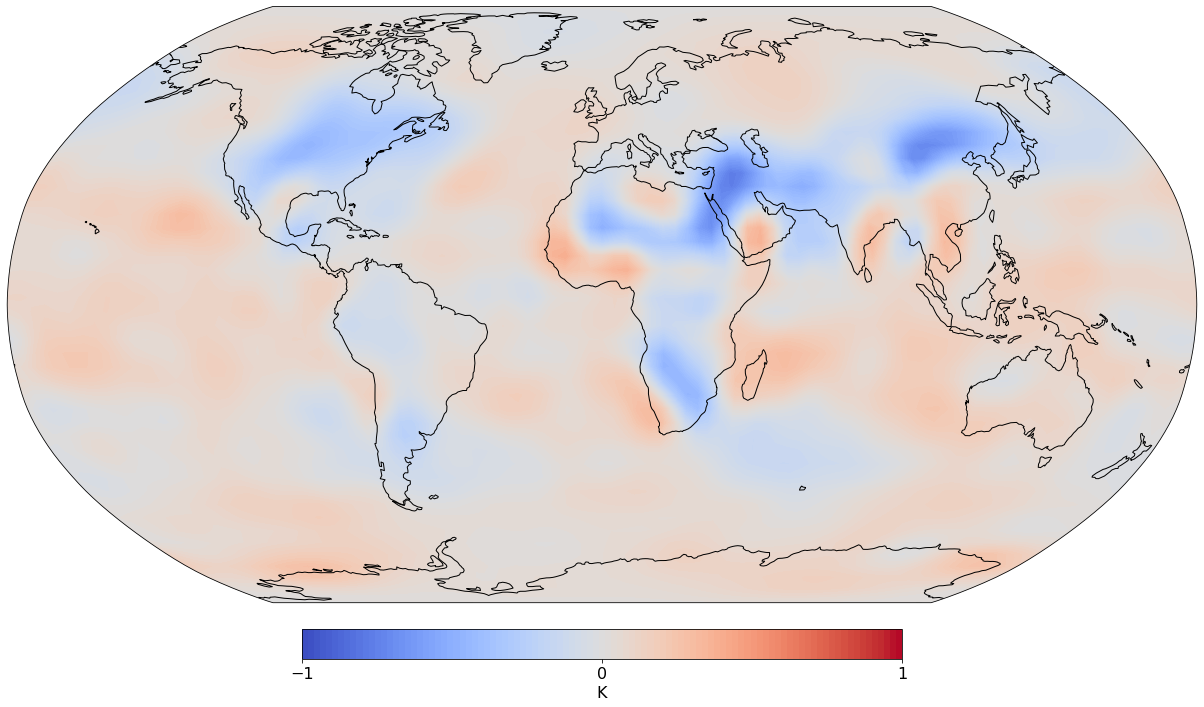

In [102]:
RobinsonPlotDev(subs52,plt.cm.coolwarm, lower_limit=-1, upper_limit=1, nlevs = 100,savefig='figures/MolMap52.png',show_cbar=False)
RobinsonPlotDev(subsSR,plt.cm.coolwarm, lower_limit=-1, upper_limit=1, nlevs = 100,savefig='figures/MolMapSR.png',show_cbar=False)
RobinsonPlotDev(subs10,plt.cm.coolwarm, lower_limit=-1, upper_limit=1, nlevs = 100,savefig='figures/MolMap10.png',show_cbar=True)